# Imports Needed

In [56]:
#Imports needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from sklearn.base import BaseEstimator, ClassifierMixin
import random
from sklearn.model_selection import KFold

# Get Data


In [57]:
#Download Academic Success Dataset
#train data
df = pd.read_csv('train.csv')

#convert targets to numeric
df['Target'] = df['Target'].map({'Dropout': 0, 'Graduate': 1, 'Enrolled': 2})

#drop target
X = df.drop('Target', axis=1)
y = df['Target']

#Split into train test and validation splits
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")


Training set size: 45910
Validation set size: 15304
Test set size: 15304


In [58]:
print("Initial data types:")
print(f"X_train type: {type(X_train)}")
print(f"y_train type: {type(y_train)}")

#Scale Data
X_train_np = X_train.to_numpy()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_np)
X_train = torch.FloatTensor(X_train_scaled)

# Convert y_train from pandas Series to tensor
y_train = torch.LongTensor(y_train.values)

print("\nFinal tensor shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

Initial data types:
X_train type: <class 'pandas.core.frame.DataFrame'>
y_train type: <class 'pandas.core.series.Series'>

Final tensor shapes:
X_train shape: torch.Size([45910, 37])
y_train shape: torch.Size([45910])


In [59]:
# preprocess data
X_val_np = X_val.values  # Convert DataFrame to numpy
X_val_scaled = scaler.transform(X_val_np)  # Use same scaler as training data
X_val = torch.FloatTensor(X_val_scaled)  # Convert to tensor
y_val = torch.LongTensor(y_val.values)  # Convert to tensor


#Multinomial Logistic Regresion





In [60]:
# def model

class MultinomialLogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultinomialLogisticRegression, self).__init__()
        # add dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(input_dim, output_dim)


        #initalize weights
        nn.init.xavier_uniform_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)


    def forward(self, x):
        return self.linear(x)


In [62]:
#cross validation
# Cross-validation setup
print("\nPerforming Cross-Validation...")
k = 5  # number of folds
cv_scores = []

# Initialize K-Fold
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

# Convert data to tensors if not already
if not torch.is_tensor(X_train):
    X_train_tensor = torch.FloatTensor(X_train.values)
    y_train_tensor = torch.LongTensor(y_train.values)
else:
    X_train_tensor = X_train
    y_train_tensor = y_train

# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_tensor)):
    print(f"\nFold {fold+1}/{k}")

    # Split data for this fold
    X_fold_train = X_train_tensor[train_idx]
    y_fold_train = y_train_tensor[train_idx]
    X_fold_val = X_train_tensor[val_idx]
    y_fold_val = y_train_tensor[val_idx]

    # Initialize model, criterion, optimizer for this fold
    fold_model = MultinomialLogisticRegression(input_dim=X_train.shape[1], output_dim=3)
    fold_criterion = nn.CrossEntropyLoss()
    fold_optimizer = torch.optim.SGD(fold_model.parameters(), lr=0.1)

    # Train the model
    best_val_loss = float('inf')
    for epoch in range(100):  # Shorter training for CV
        # Training
        fold_model.train()
        outputs = fold_model(X_fold_train)
        loss = fold_criterion(outputs, y_fold_train)

        fold_optimizer.zero_grad()
        loss.backward()
        fold_optimizer.step()

        # Validation
        fold_model.eval()
        with torch.no_grad():
            val_outputs = fold_model(X_fold_val)
            val_loss = fold_criterion(val_outputs, y_fold_val)

            if val_loss < best_val_loss:
                best_val_loss = val_loss

    # Evaluate final fold performance
    fold_model.eval()
    with torch.no_grad():
        val_outputs = fold_model(X_fold_val)
        _, predicted = torch.max(val_outputs.data, 1)
        accuracy = (predicted == y_fold_val).sum().item() / len(y_fold_val)
        cv_scores.append(accuracy)
        print(f"Fold {fold+1} Accuracy: {accuracy:.4f}")

# Print summary statistics
cv_scores = np.array(cv_scores)
print("\nCross-validation Summary:")
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")




Performing Cross-Validation...

Fold 1/5
Fold 1 Accuracy: 0.8028

Fold 2/5
Fold 2 Accuracy: 0.7975

Fold 3/5
Fold 3 Accuracy: 0.7883

Fold 4/5
Fold 4 Accuracy: 0.7931

Fold 5/5
Fold 5 Accuracy: 0.8044

Cross-validation Summary:
CV Scores: [0.80276628 0.79753866 0.78828142 0.7930734  0.80439991]
Mean CV Score: 0.7972 ± 0.0060


In [63]:
# Define hyperparameters
n_epochs = 500 #fine tuned to 5000 since acc platues to ~80 %
learning_rate = 0.1 #fined tuned

# Initialize model
model = MultinomialLogisticRegression(input_dim=X_train.shape[1], output_dim=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Lists to store metrics
train_losses = []
train_accuracies = []

#for early stopping
best_val_loss = float('inf')
patience = 10
patience_counter = 0

# Training loop
for epoch in range(n_epochs):
    # Set model to training mode
    model.train()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Calculate accuracy
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_train).sum().item()
    accuracy = correct / len(y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Store metrics
    train_losses.append(loss.item())
    train_accuracies.append(accuracy)

    #print every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, Accuracy: {100*accuracy:.2f}%')

    #validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

model.load_state_dict(torch.load('best_model.pth'))



Epoch [50/500], Loss: 0.5813, Accuracy: 77.18%
Epoch [100/500], Loss: 0.5276, Accuracy: 79.51%
Epoch [150/500], Loss: 0.5110, Accuracy: 80.18%
Epoch [200/500], Loss: 0.5031, Accuracy: 80.47%
Epoch [250/500], Loss: 0.4984, Accuracy: 80.61%
Epoch [300/500], Loss: 0.4952, Accuracy: 80.71%
Epoch [350/500], Loss: 0.4930, Accuracy: 80.82%
Epoch [400/500], Loss: 0.4912, Accuracy: 80.94%
Epoch [450/500], Loss: 0.4899, Accuracy: 80.96%
Epoch [500/500], Loss: 0.4887, Accuracy: 81.01%


<ipython-input-63-82f4182b35f7>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [64]:
#model eval
model.eval()
with torch.no_grad():
    outputs = model(X_train)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_train).sum().item() / len(y_train)
    print(f'Training Accuracy: {100*accuracy:.2f}%')



Training Accuracy: 81.00%



Test Set Results:
Test Loss: 0.4874
Test Accuracy: 81.17%


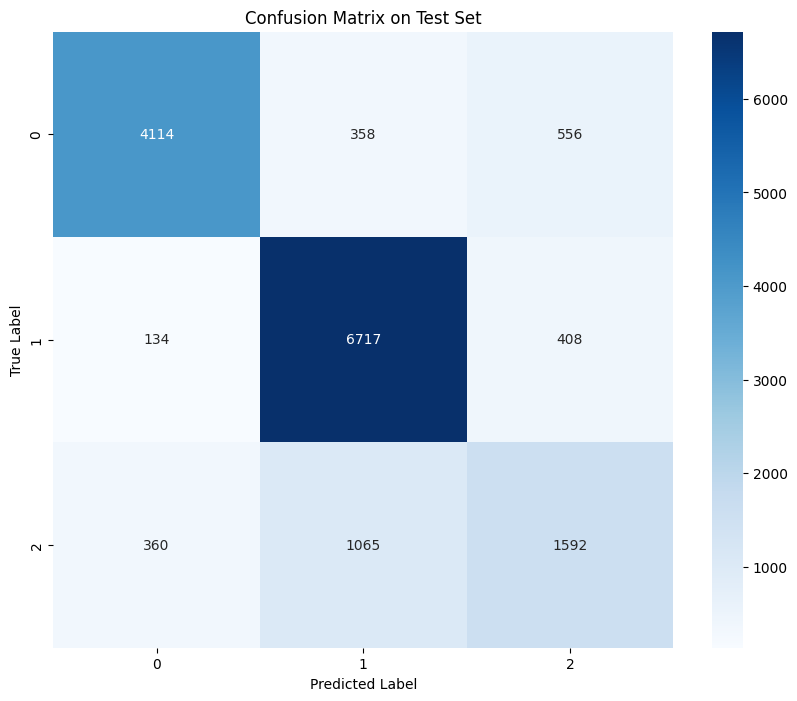


Classification Report:
              precision    recall  f1-score   support

     Dropout       0.89      0.82      0.85      5028
    Graduate       0.83      0.93      0.87      7259
    Enrolled       0.62      0.53      0.57      3017

    accuracy                           0.81     15304
   macro avg       0.78      0.76      0.77     15304
weighted avg       0.81      0.81      0.81     15304

\Example Predictions:
True Label | Predicted | Probabilities (Dropout, Graduate, Enrolled)
-----------------------------------------------------------------
Dropout    | Dropout   | 0.977, 0.003, 0.020
Graduate   | Graduate  | 0.032, 0.821, 0.147
Dropout    | Dropout   | 0.970, 0.007, 0.022
Graduate   | Graduate  | 0.014, 0.904, 0.082
Graduate   | Graduate  | 0.018, 0.881, 0.101
Dropout    | Dropout   | 0.996, 0.000, 0.004
Enrolled   | Graduate  | 0.036, 0.862, 0.102
Dropout    | Dropout   | 0.996, 0.000, 0.004
Dropout    | Dropout   | 0.995, 0.001, 0.005
Enrolled   | Graduate  | 0.074, 0

In [65]:
# Preprocess test data - use same scaler as training data
X_test_np = X_test.values
X_test_scaled = scaler.transform(X_test_np)
X_test = torch.FloatTensor(X_test_scaled)
y_test = torch.LongTensor(y_test.values)

# Set model to evaluation mode
model.eval()

# Evaluate on test set
with torch.no_grad():
    # Get model predictions
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)

    # Calculate accuracy
    _, predicted = torch.max(test_outputs.data, 1)
    test_accuracy = (predicted == y_test).sum().item() / len(y_test)

    # Get probabilities
    probabilities = F.softmax(test_outputs, dim=1)

print('\nTest Set Results:')
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {100*test_accuracy:.2f}%')

# Create confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Calculate and plot confusion matrix
cm = confusion_matrix(y_test.numpy(), predicted.numpy())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print detailed classification report
target_names = ['Dropout', 'Graduate', 'Enrolled']
print('\nClassification Report:')
print(classification_report(y_test.numpy(), predicted.numpy(),
                          target_names=target_names))

# Show some example predictions

random_indices = random.sample(range(len(y_test)), min(10, len(y_test)))

print('\Example Predictions:')
print('True Label | Predicted | Probabilities (Dropout, Graduate, Enrolled)')
print('-' * 65)

for idx in random_indices:
    true_label = target_names[y_test[idx]]
    pred_label = target_names[predicted[idx]]
    probs = probabilities[idx].numpy()
    print(f'{true_label:10} | {pred_label:9} | {probs[0]:.3f}, {probs[1]:.3f}, {probs[2]:.3f}')

In [66]:
# Get the learned coefficients (weights) from the logistic regression model.
weights = model.linear.weight.detach().numpy()

# Get the feature names
feature_names = X.columns

# Calculate the absolute values of the weights to identify the strongest relationships regardless of direction.
abs_weights = np.abs(weights)

# Find the indices of the features with the largest absolute weights for each target class.
top_feature_indices = np.argsort(abs_weights, axis=1)[:, ::-1] # Sort in descending order


for class_idx in range(3):  # Iterate over the three target classes
    print(f"\nStrongest relationships for class {target_names[class_idx]}:")
    for i in range(min(5, len(feature_names))):  # Show top 5 features
        feature_index = top_feature_indices[class_idx, i]
        feature_name = feature_names[feature_index]
        weight_value = weights[class_idx, feature_index]
        print(f"{feature_name}: {weight_value:.4f}")


Strongest relationships for class Dropout:
Curricular units 2nd sem (approved): -0.9311
Tuition fees up to date: -0.6162
Curricular units 1st sem (approved): -0.5540
Curricular units 2nd sem (grade): -0.4836
Curricular units 1st sem (credited): 0.3852

Strongest relationships for class Graduate:
Curricular units 2nd sem (approved): 1.0419
Curricular units 1st sem (approved): 0.5313
Course: -0.4757
Curricular units 1st sem (grade): 0.4411
Curricular units 1st sem (evaluations): -0.4402

Strongest relationships for class Enrolled:
Curricular units 2nd sem (evaluations): 0.5889
Curricular units 2nd sem (enrolled): -0.4730
Curricular units 2nd sem (approved): -0.2118
Mother's qualification: -0.1819
Daytime/evening attendance: 0.1774


# Gradient Boosting

In [67]:
#Graident Boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_data(X_train_scaled, y_train, X_val_scaled, y_val):
    """
    Convert scaled tensors to numpy arrays
    """
    X_train_np = X_train_scaled.numpy()
    X_val_np = X_val_scaled.numpy()
    y_train_np = y_train.numpy()
    y_val_np = y_val.numpy()
    return X_train_np, y_train_np, X_val_np, y_val_np

def train_gradient_boosting(X_train, y_train, X_val, y_val):
    """
    Train Gradient Boosting Classifier with hyperparameter tuning
    """
    # Prepare data for sklearn
    X_train_np, y_train_np, X_val_np, y_val_np = prepare_data(X_train, y_train, X_val, y_val)

    # Initialize Gradient Boosting Classifier
    gb_classifier = GradientBoostingClassifier(
        n_estimators=200,  # Number of boosting stages
        learning_rate=0.1,  # Shrinks contribution of each tree
        max_depth=5,  # Maximum tree depth
        min_samples_split=5,  # Minimum samples to split
        random_state=42
    )

    # Train the model
    gb_classifier.fit(X_train_np, y_train_np)

    # Predictions
    train_predictions = gb_classifier.predict(X_train_np)
    val_predictions = gb_classifier.predict(X_val_np)

    # Evaluation metrics
    print("Training Classification Report:")
    print(classification_report(y_train_np, train_predictions))

    print("\nValidation Classification Report:")
    print(classification_report(y_val_np, val_predictions))

    # Feature importance
    feature_importances = gb_classifier.feature_importances_

    return gb_classifier, feature_importances

# Train Gradient Boosting
gb_model, importances = train_gradient_boosting(X_train, y_train, X_val, y_val)

# Prepare numpy data for confusion matrix
X_train_np, y_train_np, X_val_np, y_val_np = prepare_data(X_train, y_train, X_val, y_val)

Training Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90     15160
           1       0.88      0.94      0.91     21775
           2       0.74      0.69      0.71      8975

    accuracy                           0.87     45910
   macro avg       0.85      0.83      0.84     45910
weighted avg       0.87      0.87      0.87     45910


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      5108
           1       0.86      0.92      0.89      7248
           2       0.65      0.61      0.63      2948

    accuracy                           0.83     15304
   macro avg       0.80      0.79      0.79     15304
weighted avg       0.83      0.83      0.83     15304



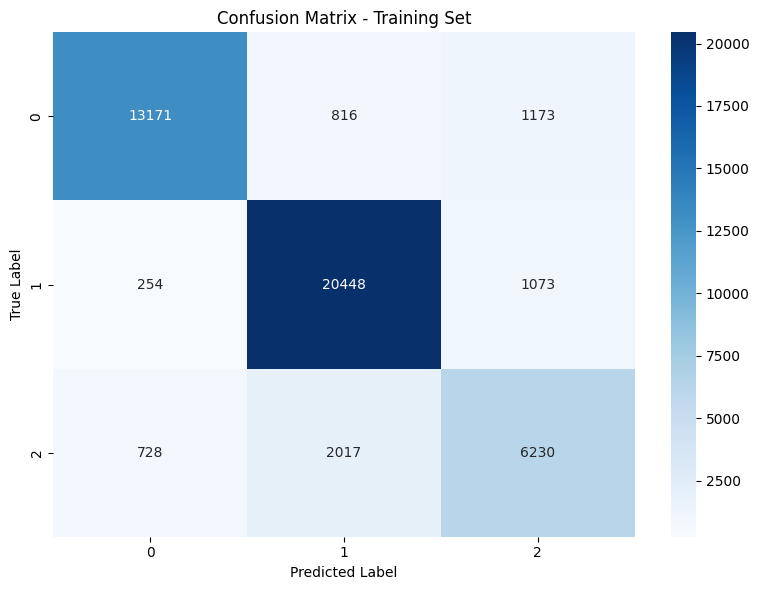

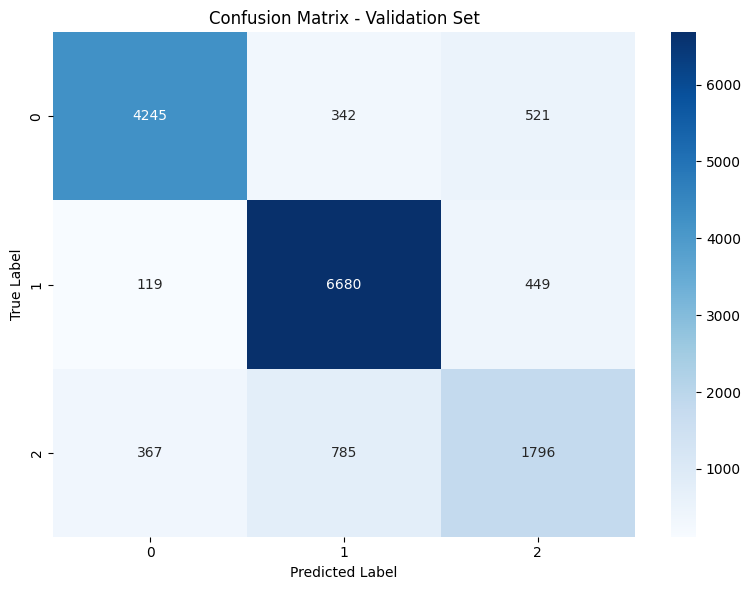

In [68]:
def plot_confusion_matrix(y_true, y_pred, title):
    """
    Plot a confusion matrix for classification results

    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels
    - title: Title for the confusion matrix plot
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))

    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(y_train_np, gb_model.predict(X_train_np), 'Confusion Matrix - Training Set')
plot_confusion_matrix(y_val_np, gb_model.predict(X_val_np), 'Confusion Matrix - Validation Set')

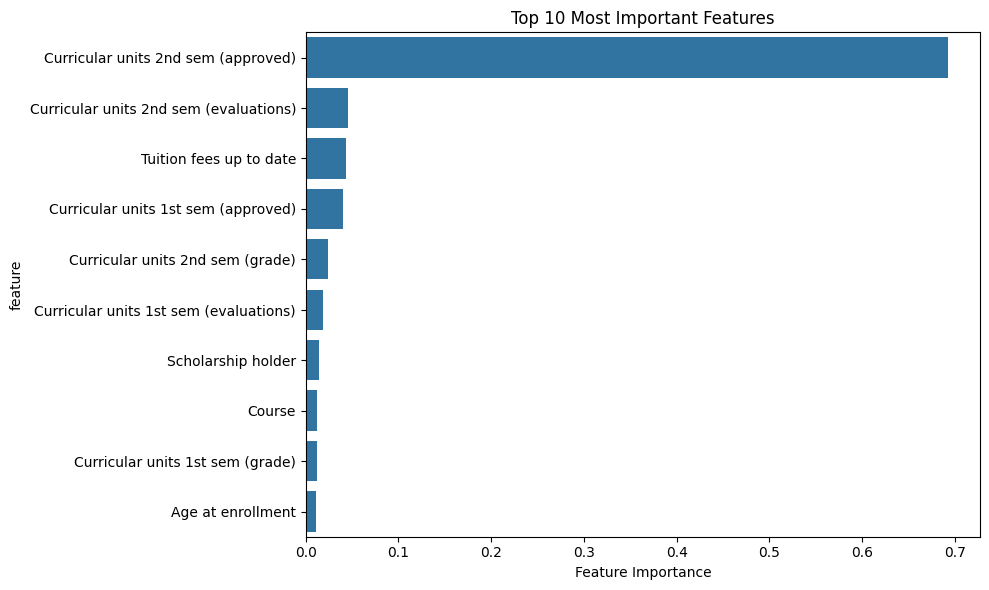


Top 5 Most Important Features for Class Dropout:
Curricular units 2nd sem (evaluations): 0.5889
Curricular units 2nd sem (enrolled): -0.4730
Curricular units 2nd sem (approved): -0.2118
Mother's qualification: -0.1819
Daytime/evening attendance: 0.1774

Top 5 Most Important Features for Class Graduate:
Curricular units 2nd sem (evaluations): 0.5889
Curricular units 2nd sem (enrolled): -0.4730
Curricular units 2nd sem (approved): -0.2118
Mother's qualification: -0.1819
Daytime/evening attendance: 0.1774

Top 5 Most Important Features for Class Enrolled:
Curricular units 2nd sem (evaluations): 0.5889
Curricular units 2nd sem (enrolled): -0.4730
Curricular units 2nd sem (approved): -0.2118
Mother's qualification: -0.1819
Daytime/evening attendance: 0.1774


In [74]:
def plot_feature_importance(feature_importances, X_train_original): # Changed X_train to X_train_original
    """
    Plot feature importance from Gradient Boosting
    """
    plt.figure(figsize=(10, 6))
    feature_names = X_train_original.columns  # Access columns from original DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values('importance', ascending=False)

    sns.barplot(x='importance', y='feature', data=importance_df.head(10))
    plt.title('Top 10 Most Important Features')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()

    #print features over 3 targets with 5 shown each
    for target in range(3):
        print(f"\nTop 5 Most Important Features for Class {target_names[target]}:")
        for i in range(min(5, len(feature_names))):  # Show top 5 features
          feature_index = top_feature_indices[class_idx, i]
          feature_name = feature_names[feature_index]
          weight_value = weights[class_idx, feature_index]
          print(f"{feature_name}: {weight_value:.4f}")


# Call plot_feature_importance with the original DataFrame 'X'
plot_feature_importance(importances, X) # Pass the original DataFrame 'X'

# Random Forest

Training Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88     15160
           1       0.85      0.93      0.89     21775
           2       0.67      0.63      0.65      8975

    accuracy                           0.84     45910
   macro avg       0.82      0.80      0.81     45910
weighted avg       0.84      0.84      0.84     45910


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.81      0.86      5108
           1       0.84      0.93      0.88      7248
           2       0.63      0.59      0.61      2948

    accuracy                           0.82     15304
   macro avg       0.79      0.77      0.78     15304
weighted avg       0.82      0.82      0.82     15304



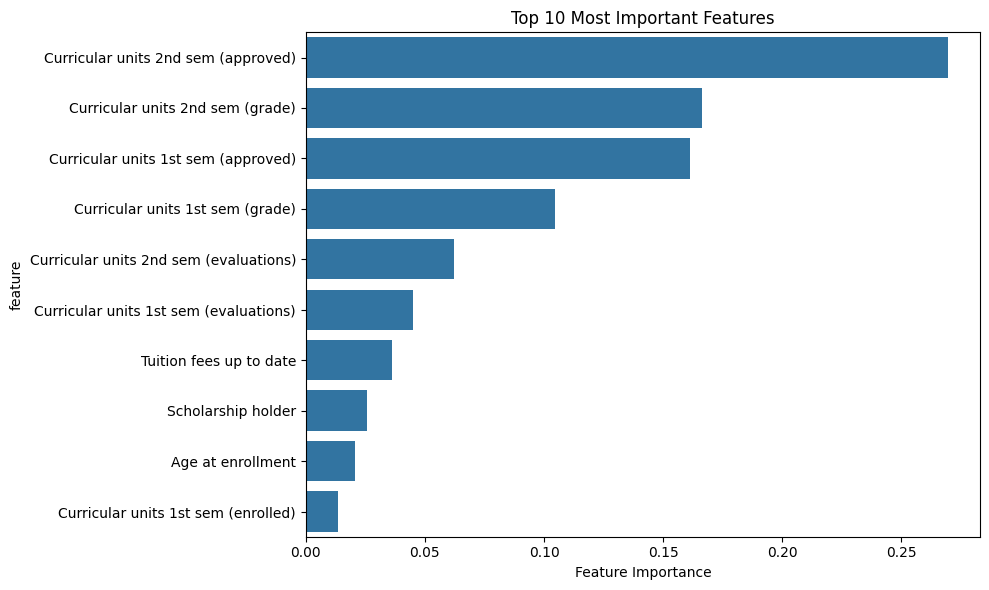


Top 5 Most Important Features for Class Dropout:
Curricular units 2nd sem (evaluations): 0.5889
Curricular units 2nd sem (enrolled): -0.4730
Curricular units 2nd sem (approved): -0.2118
Mother's qualification: -0.1819
Daytime/evening attendance: 0.1774

Top 5 Most Important Features for Class Graduate:
Curricular units 2nd sem (evaluations): 0.5889
Curricular units 2nd sem (enrolled): -0.4730
Curricular units 2nd sem (approved): -0.2118
Mother's qualification: -0.1819
Daytime/evening attendance: 0.1774

Top 5 Most Important Features for Class Enrolled:
Curricular units 2nd sem (evaluations): 0.5889
Curricular units 2nd sem (enrolled): -0.4730
Curricular units 2nd sem (approved): -0.2118
Mother's qualification: -0.1819
Daytime/evening attendance: 0.1774
Training Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88     15160
           1       0.85      0.93      0.89     21775
           2       0.67      0.63      0.

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_data(X_train_scaled, y_train, X_val_scaled, y_val):
    """
    Convert scaled numpy arrays to original format for sklearn
    """
    X_train_np = X_train_scaled.numpy()
    X_val_np = X_val_scaled.numpy()
    y_train_np = y_train.numpy()
    y_val_np = y_val.numpy()
    return X_train_np, y_train_np, X_val_np, y_val_np

def train_random_forest(X_train, y_train, X_val, y_val):
    """
    Train Random Forest Classifier with hyperparameter tuning
    """
    # Prepare data for sklearn
    X_train_np, y_train_np, X_val_np, y_val_np = prepare_data(X_train, y_train, X_val, y_val)

    # Initialize Random Forest with optimized parameters
    rf_classifier = RandomForestClassifier(
        n_estimators=100,  # Number of trees
        max_depth=10,      # Maximum depth of trees
        min_samples_split=5,  # Minimum samples required to split
        min_samples_leaf=2,   # Minimum samples in leaf node
        random_state=42
    )

    # Train the model
    rf_classifier.fit(X_train_np, y_train_np)

    # Predictions
    train_predictions = rf_classifier.predict(X_train_np)
    val_predictions = rf_classifier.predict(X_val_np)

    # Evaluation metrics
    print("Training Classification Report:")
    print(classification_report(y_train_np, train_predictions))

    print("\nValidation Classification Report:")
    print(classification_report(y_val_np, val_predictions))

    # Feature importance
    feature_importances = rf_classifier.feature_importances_

    return rf_classifier, feature_importances


# Train Random Forest
rf_model, importances = train_random_forest(X_train, y_train, X_val, y_val)

# Plot feature importances
plot_feature_importance(importances, X) # Pass the original DataFrame 'X'

# Train Random Forest
rf_model, importances = train_random_forest(X_train, y_train, X_val, y_val)


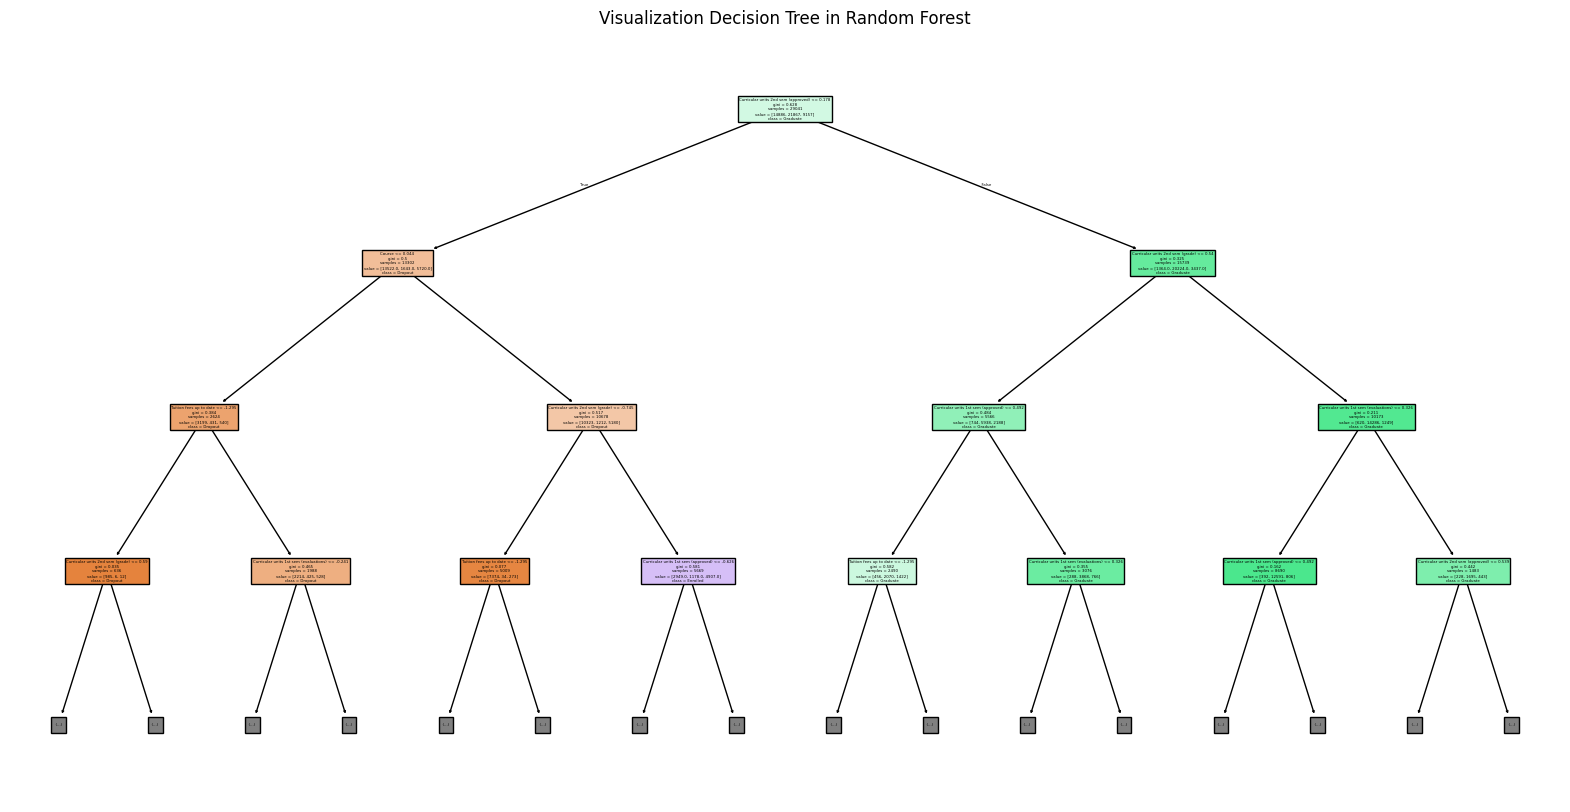

In [79]:
#Visualize Decision Tree in Random Forest
# Prepare data for visualization
X_train_np, y_train_np, X_val_np, y_val_np = prepare_data(X_train, y_train, X_val, y_val)

# Tree Visualization (first tree in the forest)
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(rf_model.estimators_[0],
         feature_names=X.columns,
         class_names=['Dropout', 'Graduate', 'Enrolled'],
         filled=True,
         max_depth=3)  # Limiting depth for visibility
plt.title('Visualization Decision Tree in Random Forest')
plt.show()

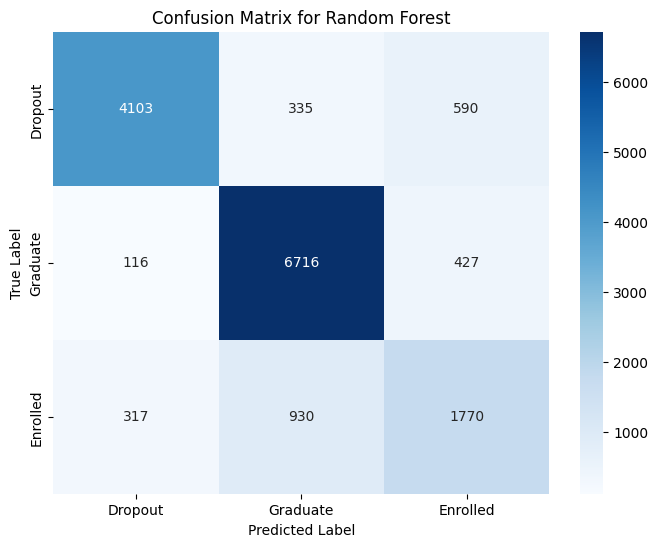

In [80]:
X_test_np = X_test.numpy() # changed X_test.values to X_test.numpy()
y_pred_rf = rf_model.predict(X_test_np)

# Create and plot the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dropout', 'Graduate', 'Enrolled'],
            yticklabels=['Dropout', 'Graduate', 'Enrolled'])
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Ensemble Learning

Ensemble Classifier - Training Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89     15160
           1       0.87      0.94      0.90     21775
           2       0.71      0.67      0.69      8975

    accuracy                           0.86     45910
   macro avg       0.84      0.82      0.83     45910
weighted avg       0.86      0.86      0.86     45910


Ensemble Classifier - Validation Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      5108
           1       0.85      0.93      0.89      7248
           2       0.65      0.60      0.62      2948

    accuracy                           0.83     15304
   macro avg       0.80      0.78      0.79     15304
weighted avg       0.83      0.83      0.83     15304



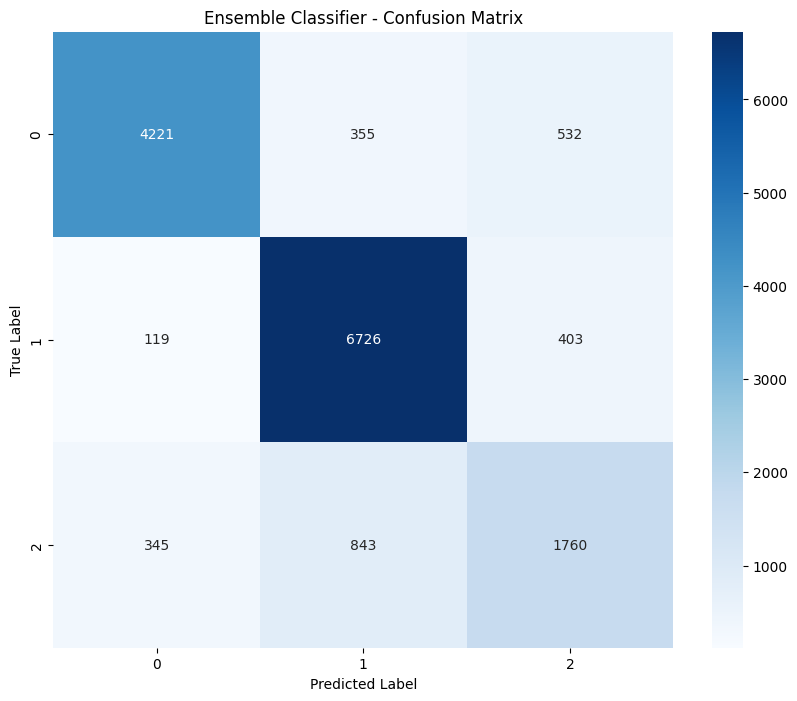

(VotingClassifier(estimators=[('random_forest',
                               RandomForestClassifier(max_depth=10,
                                                      min_samples_leaf=2,
                                                      min_samples_split=5,
                                                      random_state=42)),
                              ('gradient_boosting',
                               GradientBoostingClassifier(max_depth=5,
                                                          min_samples_split=5,
                                                          n_estimators=200,
                                                          random_state=42,
                                                          subsample=0.8))],
                  voting='soft'),
 array([[0.01956015, 0.93864859, 0.04179126],
        [0.88028037, 0.07109079, 0.04862884],
        [0.01471679, 0.94797584, 0.03730736],
        ...,
        [0.18196174, 0.08007989, 0.73795837],
  

In [89]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_data(X_train_scaled, y_train, X_val_scaled, y_val):
    """
    Convert scaled tensors to numpy arrays
    """
    X_train_np = X_train_scaled.numpy()
    X_val_np = X_val_scaled.numpy()
    y_train_np = y_train.numpy()
    y_val_np = y_val.numpy()
    return X_train_np, y_train_np, X_val_np, y_val_np

def create_ensemble_classifier(X_train, y_train, X_val, y_val):
    """
    Create an ensemble classifier using soft voting with Random Forest and Gradient Boosting
    """
    # Prepare data for sklearn
    X_train_np, y_train_np, X_val_np, y_val_np = prepare_data(X_train, y_train, X_val, y_val)

    # Initialize base classifiers
    rf_classifier = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
    )

    gb_classifier = GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        min_samples_split=5,
        random_state=42,
        # Add probability estimation
        subsample=0.8  # Additional regularization
    )

    # Create Voting Classifier with soft voting
    ensemble_classifier = VotingClassifier(
        estimators=[
            ('random_forest', rf_classifier),
            ('gradient_boosting', gb_classifier)
        ],
        voting='soft'  # Use soft voting to leverage probability predictions
    )

    # Fit the ensemble classifier
    ensemble_classifier.fit(X_train_np, y_train_np)

    # Predictions
    train_predictions = ensemble_classifier.predict(X_train_np)
    val_predictions = ensemble_classifier.predict(X_val_np)
    ensemble_predictions = ensemble_classifier.predict(X_test_np)  # Predict on test data

    # Probability predictions
    train_probabilities = ensemble_classifier.predict_proba(X_train_np)
    val_probabilities = ensemble_classifier.predict_proba(X_val_np)

    # Evaluation metrics
    print("Ensemble Classifier - Training Classification Report:")
    print(classification_report(y_train_np, train_predictions))

    print("\nEnsemble Classifier - Validation Classification Report:")
    print(classification_report(y_val_np, val_predictions))

    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_val_np, val_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Ensemble Classifier - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return ensemble_classifier, train_probabilities, val_probabilities, ensemble_predictions
create_ensemble_classifier(X_train, y_train, X_val, y_val)

# Classification Comparison

Multinomial Logistic Regression Test Accuracy: 81.17%
Gradient Boosting Test Accuracy: 83.14%
Random Forest Test Accuracy: 82.26%
Ensemble Test Accuracy: 83.04%
Ensemble Classifier - Training Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89     15160
           1       0.87      0.94      0.90     21775
           2       0.71      0.67      0.69      8975

    accuracy                           0.86     45910
   macro avg       0.84      0.82      0.83     45910
weighted avg       0.86      0.86      0.86     45910


Ensemble Classifier - Validation Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      5108
           1       0.85      0.93      0.89      7248
           2       0.65      0.60      0.62      2948

    accuracy                           0.83     15304
   macro avg       0.80      0.78      0.79     15304
weighted avg       0.

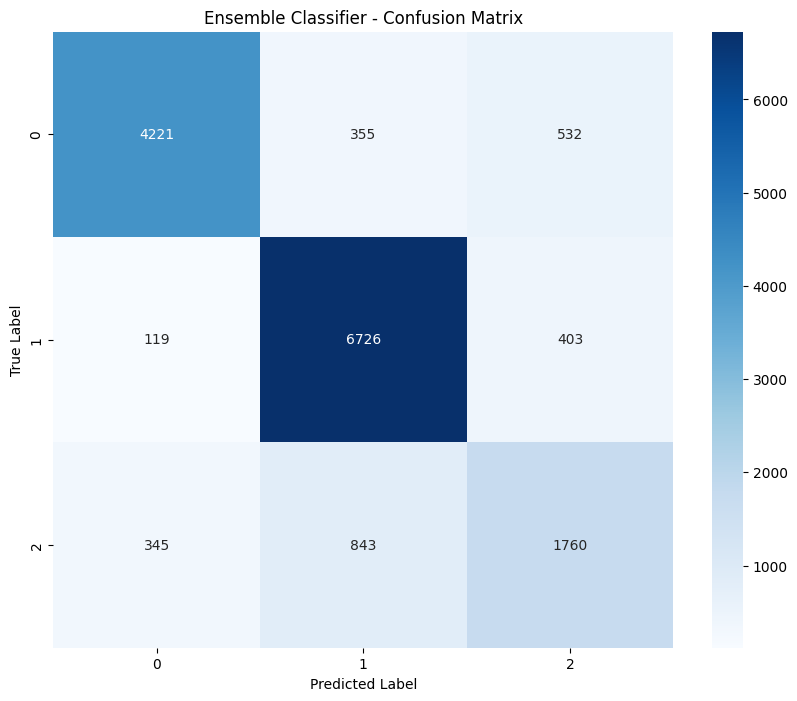

--------------------------------------------------
Model Statistics:
--------------------------------------------------
Model: Logistic Regression
Accuracy: 0.8117
Macro Precision: 0.7803
Macro Recall: 0.7571
Macro F1-score: 0.7659
Weighted Precision: 0.8075
Weighted Recall: 0.8117
Weighted F1-score: 0.8070
--------------------------------------------------
Model: Gradient Boosting
Accuracy: 0.8314
Macro Precision: 0.8026
Macro Recall: 0.7888
Macro F1-score: 0.7947
Weighted Precision: 0.8295
Weighted Recall: 0.8314
Weighted F1-score: 0.8294
--------------------------------------------------
Model: Random Forest
Accuracy: 0.8226
Macro Precision: 0.7937
Macro Recall: 0.7760
Macro F1-score: 0.7831
Weighted Precision: 0.8215
Weighted Recall: 0.8226
Weighted F1-score: 0.8202
--------------------------------------------------
Model: Ensemble
Accuracy: 0.8304
Macro Precision: 0.8025
Macro Recall: 0.7860
Macro F1-score: 0.7928
Weighted Precision: 0.8287
Weighted Recall: 0.8304
Weighted F1-scor

In [93]:
# After training the models (Multinomial Logistic Regression, Gradient Boosting, Random Forest, and Ensemable Learning),
# you can access the evaluation metrics from the classification_report and other outputs
# to calculate overall statistics.

#  Accessing Test Accuracy for Multinomial Logistic Regression,
print(f"Multinomial Logistic Regression Test Accuracy: {100*test_accuracy:.2f}%")
print(f"Gradient Boosting Test Accuracy: {100*accuracy_gb:.2f}%")
print(f"Random Forest Test Accuracy: {100*accuracy_rf:.2f}%")
print(f"Ensemble Test Accuracy: {100*accuracy_ensemble:.2f}%")


# Example: Extracting precision, recall, F1-score from the classification report for Random Forest:
target_names = ['Dropout', 'Graduate', 'Enrolled']

# Calculate statistics for all models
def get_stats(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    accuracy = report["accuracy"]
    macro_precision = report["macro avg"]["precision"]
    macro_recall = report["macro avg"]["recall"]
    macro_f1 = report["macro avg"]["f1-score"]
    weighted_precision = report["weighted avg"]["precision"]
    weighted_recall = report["weighted avg"]["recall"]
    weighted_f1 = report["weighted avg"]["f1-score"]
    return accuracy, macro_precision, macro_recall, macro_f1, weighted_precision, weighted_recall, weighted_f1

# Assuming you have already trained the models and predicted:
# y_pred_lr, y_pred_gb, y_pred_rf

# Logistic Regression
accuracy_lr, macro_p_lr, macro_r_lr, macro_f1_lr, weighted_p_lr, weighted_r_lr, weighted_f1_lr = get_stats(y_test.numpy(), predicted.numpy(), "Logistic Regression")
# Gradient Boosting
accuracy_gb, macro_p_gb, macro_r_gb, macro_f1_gb, weighted_p_gb, weighted_r_gb, weighted_f1_gb = get_stats(y_test.numpy(), gb_model.predict(X_test_np), "Gradient Boosting")
# Random Forest
accuracy_rf, macro_p_rf, macro_r_rf, macro_f1_rf, weighted_p_rf, weighted_r_rf, weighted_f1_rf = get_stats(y_test.numpy(), y_pred_rf, "Random Forest")
# Ensemable Learning
ensemble_model, train_probs, val_probs, ensemble_predictions = create_ensemble_classifier(X_train, y_train, X_val, y_val)
accuracy_ensemble, macro_p_ensemble, macro_r_ensemble, macro_f1_ensemble, weighted_p_ensemble, weighted_r_ensemble, weighted_f1_ensemble = get_stats(y_test.numpy(), ensemble_predictions, "Ensemble")


# Print the statistics
print("-"*50)
print("Model Statistics:")
print("-"*50)

def print_stats(accuracy, macro_p, macro_r, macro_f1, weighted_p, weighted_r, weighted_f1, model_name):
  print(f"Model: {model_name}")
  print(f"Accuracy: {accuracy:.4f}")
  print(f"Macro Precision: {macro_p:.4f}")
  print(f"Macro Recall: {macro_r:.4f}")
  print(f"Macro F1-score: {macro_f1:.4f}")
  print(f"Weighted Precision: {weighted_p:.4f}")
  print(f"Weighted Recall: {weighted_r:.4f}")
  print(f"Weighted F1-score: {weighted_f1:.4f}")
  print("-"*50)

print_stats(accuracy_lr, macro_p_lr, macro_r_lr, macro_f1_lr, weighted_p_lr, weighted_r_lr, weighted_f1_lr, "Logistic Regression")
print_stats(accuracy_gb, macro_p_gb, macro_r_gb, macro_f1_gb, weighted_p_gb, weighted_r_gb, weighted_f1_gb, "Gradient Boosting")
print_stats(accuracy_rf, macro_p_rf, macro_r_rf, macro_f1_rf, weighted_p_rf, weighted_r_rf, weighted_f1_rf, "Random Forest")
print_stats(accuracy_ensemble, macro_p_ensemble, macro_r_ensemble, macro_f1_ensemble, weighted_p_ensemble, weighted_r_ensemble, weighted_f1_ensemble, "Ensemble")

In [94]:
# prompt: Compare all of the different models statistics and print which is the best

from sklearn.metrics import accuracy_score

# Assuming y_test is a NumPy array or a tensor that can be converted to one
y_test_np = y_test.numpy()

# Multinomial Logistic Regression
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted_mnl = torch.max(outputs.data, 1)
accuracy_mnl = accuracy_score(y_test_np, predicted_mnl)

# Gradient Boosting
predicted_gb = gb_model.predict(X_test_np)
accuracy_gb = accuracy_score(y_test_np, predicted_gb)

# Random Forest
predicted_rf = rf_model.predict(X_test_np)
accuracy_rf = accuracy_score(y_test_np, predicted_rf)

# Ensemble
accuracy_ensemble = accuracy_score(y_test_np, ensemble_predictions)

# Compare accuracies
print("\nModel Accuracy Comparison:")
print(f"Multinomial Logistic Regression: {accuracy_mnl:.4f}")
print(f"Gradient Boosting: {accuracy_gb:.4f}")
print(f"Random Forest: {accuracy_rf:.4f}")
print(f"Ensemble: {accuracy_ensemble:.4f}")

# Determine the best model
best_model = max([(accuracy_mnl, "Multinomial Logistic Regression"),
                  (accuracy_gb, "Gradient Boosting"),
                  (accuracy_rf, "Random Forest"),
                  (accuracy_ensemble, "Ensemble")], key=lambda x: x[0])

print(f"\nBest Model: {best_model[1]} with accuracy {best_model[0]:.4f}")


Model Accuracy Comparison:
Multinomial Logistic Regression: 0.8117
Gradient Boosting: 0.8314
Random Forest: 0.8226
Ensemble: 0.8304

Best Model: Gradient Boosting with accuracy 0.8314


In [102]:
import pandas as pd
import numpy as np

# Load the test data
test_data = pd.read_csv('test.csv')

# Print column information to debug
print("Training data columns:", len(X.columns))
print("Test data columns:", len(test_data.columns))
print("\nTest data columns:", test_data.columns.tolist())
print("\nTraining data columns:", X.columns.tolist())

# Find any missing columns in test data
missing_cols = set(X.columns) - set(test_data.columns)
print("\nMissing columns in test data:", missing_cols)

# Ensure test data has same columns as training data (except target)
test_features = pd.DataFrame()
for col in X.columns:
    if col in test_data.columns:
        test_features[col] = test_data[col]
    else:
        test_features[col] = 0  # or another appropriate default value

# Now preprocess with scaler
test_data_scaled = scaler.transform(test_features)
test_data_scaled_tensor = torch.FloatTensor(test_data_scaled)

# Get predictions
predictions = rf_model.predict(test_data_scaled)

# Map numeric predictions back to string labels if needed
label_map = {0: 'Dropout', 1: 'Graduate', 2: 'Enrolled'}
predictions_mapped = [label_map[pred] for pred in predictions]

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_data['id'],
    'target': predictions_mapped  # or predictions if numeric labels are expected
})

# Save to CSV
submission.to_csv('submission.csv', index=False)

# Print sample of predictions
print("\nSample of predictions:")
print(submission.head())
print("\nValue counts of predictions:")
print(submission['target'].value_counts())

Training data columns: 37
Test data columns: 37

Test data columns: ['id', 'Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluation

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



Sample of predictions:
      id    target
0  76518   Dropout
1  76519  Graduate
2  76520  Graduate
3  76521  Graduate
4  76522  Enrolled

Value counts of predictions:
target
Graduate    27062
Dropout     14785
Enrolled     9165
Name: count, dtype: int64


## Model Comparison Using Weights and Biases

In [103]:
import wandb
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Initialize wandb
wandb.init(project="student-success-prediction", name="model-comparison")

# Define the config (hyperparameters and metadata)
config = {
    "dataset_size": len(X_train),
    "test_size": len(X_test),
    "random_seed": 42,
    "feature_count": X_train.shape[1]
}
wandb.config.update(config)

# Function to log model metrics
def log_model_metrics(y_true, y_pred, model_name):
    # Get classification report
    report = classification_report(y_true, y_pred, target_names=['Dropout', 'Graduate', 'Enrolled'],
                                 output_dict=True)

    # Log metrics
    metrics = {
        f"{model_name}/accuracy": report['accuracy'],
        f"{model_name}/macro_avg_precision": report['macro avg']['precision'],
        f"{model_name}/macro_avg_recall": report['macro avg']['recall'],
        f"{model_name}/macro_avg_f1": report['macro avg']['f1-score'],
        f"{model_name}/weighted_avg_f1": report['weighted avg']['f1-score']
    }

    # Log per-class metrics
    for class_name in ['Dropout', 'Graduate', 'Enrolled']:
        metrics.update({
            f"{model_name}/{class_name}_precision": report[class_name]['precision'],
            f"{model_name}/{class_name}_recall": report[class_name]['recall'],
            f"{model_name}/{class_name}_f1": report[class_name]['f1-score']
        })

    # Create and log confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    wandb.log({
        f"{model_name}/confusion_matrix": wandb.plot.confusion_matrix(
            y_true=y_true,
            preds=y_pred,
            class_names=['Dropout', 'Graduate', 'Enrolled']
        )
    })

    # Log all metrics
    wandb.log(metrics)

# Log Logistic Regression results
log_model_metrics(y_test.numpy(), predicted.numpy(), "logistic_regression")

# Log Random Forest results
log_model_metrics(y_test.numpy(), y_pred_rf, "random_forest")

# Log Gradient Boosting results
log_model_metrics(y_test.numpy(), gb_model.predict(X_test_np), "gradient_boosting")

# Log Ensemble results
log_model_metrics(y_test.numpy(), ensemble_predictions, "ensemble")

# Create a summary table
summary_table = wandb.Table(columns=["Model", "Accuracy", "Macro F1", "Weighted F1"])

# Add rows for each model
for model_name in ["logistic_regression", "random_forest", "gradient_boosting", "ensemble"]:
    metrics = wandb.run.summary
    summary_table.add_data(
        model_name,
        metrics[f"{model_name}/accuracy"],
        metrics[f"{model_name}/macro_avg_f1"],
        metrics[f"{model_name}/weighted_avg_f1"]
    )

wandb.log({"model_comparison": summary_table})

# Optional: Feature Importance Visualization (for RF and GB)
feature_importance_table = wandb.Table(
    columns=["Feature", "RF_Importance", "GB_Importance"]
)

# Get feature importances
rf_importances = rf_model.feature_importances_
gb_importances = gb_model.feature_importances_

for feature, rf_imp, gb_imp in zip(X.columns, rf_importances, gb_importances):
    feature_importance_table.add_data(feature, rf_imp, gb_imp)

wandb.log({"feature_importance": feature_importance_table})

# Close the wandb run
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


ensemble/Dropout_f1,▁
ensemble/Dropout_precision,▁
ensemble/Dropout_recall,▁
ensemble/Enrolled_f1,▁
ensemble/Enrolled_precision,▁
ensemble/Enrolled_recall,▁
ensemble/Graduate_f1,▁
ensemble/Graduate_precision,▁
ensemble/Graduate_recall,▁
ensemble/accuracy,▁
ensemble/macro_avg_f1,▁
